# Modeling Churn and CLV with Markov Chains



In [40]:
# import modules
import itertools as it
from collections import Counter

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# settings for plots
%matplotlib inline
sns.set(font_scale=1.3)
sns.set_palette(sns.husl_palette(3))
green = sns.husl_palette(3)[1]
blue = sns.husl_palette(3)[2]

# load data and set column labels
transactions = pd.read_table('purchases.txt', header=None)
transactions.columns = ['user_id', 'value', 'date']

In [41]:
# examine data
transactions.head()

,user_id,value,date
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25


In [42]:
# examine data
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
user_id    51243 non-null int64
value      51243 non-null float64
date       51243 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


The data are individual purchases and include user id, the date of purchase, and the value of the purchase. Note that the date is of the `object` type. This needs to be converted to a `datetime`.

In [43]:
## Deal with datetime issues

# convert date to datetime
transactions['date'] = pd.to_datetime(transactions.date)

# set date as the index
transactions = transactions.set_index('date')

# convert dates to years
transactions = transactions.to_period('A')

# reset index
transactions = transactions.reset_index()

In [44]:
# examine descriptive statistics
transactions.describe()

,user_id,value
count,51243.000000,51243.000000
mean,108934.547938,62.337195
std,67650.610139,156.606801
min,10.000000,5.000000
25%,57720.000000,25.000000
50%,102440.000000,30.000000
75%,160525.000000,60.000000
max,264200.000000,4500.000000


Three matrices are needed to analyze the recency, frequency, and monetary value of each customer.

In [45]:
# get purchase frequency matrix
freq = pd.crosstab(transactions.user_id, transactions.date)

# examine purchase frequency matrix
freq.head()

date,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
user_id,,,,,,,,,,,
10,1,0,0,0,0,0,0,0,0,0,0
80,1,0,1,0,1,0,1,0,1,1,1
90,1,1,1,1,1,1,1,2,1,0,0
120,0,0,0,0,0,0,0,1,0,0,0
130,1,0,1,0,0,0,0,0,0,0,0


In [46]:
# encode frequency segments
for y in freq.columns:
    freq.loc[:, y] = freq.loc[:, y].apply(lambda x: 2 if x > 1 else x)

In [47]:
freq.head()

date,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
user_id,,,,,,,,,,,
10,1,0,0,0,0,0,0,0,0,0,0
80,1,0,1,0,1,0,1,0,1,1,1
90,1,1,1,1,1,1,1,2,1,0,0
120,0,0,0,0,0,0,0,1,0,0,0
130,1,0,1,0,0,0,0,0,0,0,0


In [48]:
# get frequency states
F = freq.values.copy()
n, m = F.shape
for i in range(n):
    for j in range(m):
        if (m != 0) and F[i, j] == 0:
            F[i, j] = F[i, j-1]

np.unique(F)

array([0, 1, 2], dtype=int64)

In [49]:
# get purchase value matrix and examine
mon = pd.crosstab(transactions.user_id, transactions.date, transactions.value, aggfunc=np.sum)
mon.describe()

date,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,1225.000000,2036.000000,4112.000000,3913.000000,4423.000000,4337.000000,4123.000000,5289.000000,5187.000000,4923.000000,5398.000000
mean,66.991347,55.997294,55.997082,58.741089,57.984741,66.893456,73.718130,70.894940,77.426293,87.886492,88.624329
std,146.045770,107.189257,142.884489,150.701224,121.490009,179.650688,162.258198,156.988972,208.346206,232.693344,224.356897
min,7.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,25.000000,20.000000,20.000000,20.000000,20.000000,25.000000,30.000000,30.000000,30.000000,30.000000,30.000000
50%,35.000000,30.000000,30.000000,30.000000,30.000000,40.000000,45.000000,40.000000,40.000000,45.000000,50.000000
75%,60.000000,50.000000,55.000000,60.000000,60.000000,60.000000,70.000000,60.000000,65.000000,80.000000,85.000000
max,3050.000000,3000.000000,3600.000000,4007.000000,4700.000000,5750.000000,3500.000000,4000.000000,4000.000000,5000.000000,4500.000000


In [50]:
mon.head()

date,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
user_id,,,,,,,,,,,
10,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,50.0,NaN,60.0,NaN,70.0,NaN,80.0,NaN,80.0,80.0,80.0
90,153.0,150.0,150.0,150.0,75.0,80.0,100.0,200.0,100.0,NaN,NaN
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN
130,40.0,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have assigned three monetary states:

* 0: never made a purchase
* 1: last purchase was less than \$30
* 2: last purchase was greater than \$30

In [51]:
# get monetary states
M = mon.values.copy()
M[np.isnan(M)] = 0
M[np.where(np.logical_and(M>0, M<30))] = 1
M[np.where(M>=30)]=2
for i in range(n):
    for j in range(m):
        if j > 0 and M[i,j] == 0:
            M[i,j] = M[i, j-1]

np.unique(M)

array([0., 1., 2.])

In [52]:
# get recency states
R = freq.values.copy()
for i in range(n):
    for j in range(m):
        if (j == 0) and (R[i, j] > 0):
            R[i, j] = 1
        elif j > 0:
            if R[i, j] > 0:
                R[i, j] = 1
            elif (R[i, j-1] > 0):
                R[i, j] = R[i, j-1] + 1
np.unique(R)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [53]:
# examine R
pd.DataFrame(R).head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,2,3,4,5,6,7,8,9,10,11
1,1,2,1,2,1,2,1,2,1,1,1
2,1,1,1,1,1,1,1,1,1,2,3
3,0,0,0,0,0,0,0,1,2,3,4
4,1,2,1,2,3,4,5,6,7,8,9


We have assigned 22 total states:

20 are the cartesian product of:
* 2 monetary states (high and low)
* 2 freqency states (high and low)
* 5 recency states (purchase this period through 4 periods ago)

1 absorbing or churn state (recency greater than five)

1 inactive state for customers that have not yet made a purchase

States are encoded as tuples of the form (M, F, R), and a hashmap is used to convert tuples to integers so that a state matrix can be created.

In [54]:
# initialize hashmap
state_map = dict()

# get possible states for m, f, r
ms = [0, 1, 2]
fs = [0, 1, 2]
rs = list(range(11))

# get cartesian product of m, f, r states
states = it.product(ms, fs, rs)

# assign inactive states to 0
for state in states:
    if state[0] == 0 or state[1] == 0:
        state_map[state] = 0

# assign states 1-21 to customers who have made purchases but not yet churned
state = 1
for r in range(1, 12):
    state_tuple = (2, 2, r)
    state_map[state_tuple] = state
    state += 1
    state_tuple = (2, 1, r)
    state_map[state_tuple] = state
    state += 1
    state_tuple = (1, 2, r)
    state_map[state_tuple] = state
    state += 1
    state_tuple = (1, 1, r)
    state_map[state_tuple] = state
    state += 1

# assign state 21 to the absorbing state (churn, recency greater than five)
for state in state_map.keys():
    if state[2] > 5:
        state_map[state] = 21

In [55]:
# examine state_map values
unique_states = np.unique(list(state_map.values()))
unique_states

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [56]:
# collect M, F, R into a single array
MFR = np.zeros((n, m, 3))
MFR[:, :, 0] = M.copy()
MFR[:, :, 1] = F.copy()
MFR[:, :, 2] = R.copy()

Indexing into the collected MFR array returns tuples, which can be fed into the state map and used to populate a state matrix, which shows every user's state at every period.

In [57]:
# initialize state matrix
S = np.zeros((n, m), dtype=int)
for i in range(n):
    for j in range(m):
        # each entry of S is the corresponding tuple from MFR, passed through the state_map
        S[i, j] = int(state_map[tuple(MFR[i, j, :].astype(int))])

In [58]:
# examine S
pd.DataFrame(S).head()

,0,1,2,3,4,5,6,7,8,9,10
0,2,6,10,14,18,21,21,21,21,21,21
1,2,6,2,6,2,6,2,6,2,2,2
2,2,2,2,2,2,2,2,1,2,6,10
3,0,0,0,0,0,0,0,4,8,12,16
4,2,6,2,6,10,14,18,21,21,21,21


From this state matrix, transition matrices can be calculated by counting state changes between periods.

In [59]:
# get num states
n_states = len(unique_states)

In [60]:
# initialize transition array. Each slice is a 22x22 transition matrix, one for each transition between periods
T_freq = np.zeros((n_states, n_states, 10), dtype=int)

for p in range(10):
    for r in range(n):
        i = S[r, p]
        j = S[r, p+1]
        T_freq[i, j, p] += 1
        
# examine one slice
T_freq[1:10, 1:10, 3]

array([[  92,  135,    1,   35,   82,    0,    0,    0,    0],
       [ 142, 1148,    1,   84,    0, 1011,    0,    0,    0],
       [   0,    0,    2,    8,    0,    0,    9,    0,    0],
       [  38,  101,    7,  298,    0,    0,    0,  719,    0],
       [  18,   59,    1,   12,    0,    0,    0,    0,  127],
       [  62,  248,    0,   40,    0,    0,    0,    0,    0],
       [   0,    0,    2,    0,    0,    0,    0,    0,    0],
       [  24,   69,    4,   91,    0,    0,    0,    0,    0],
       [   0,    3,    0,    1,    0,    0,    0,    0,    0]])

Per period transition frequency matrices are collapsed into a single transition frequency matrix for the whole dataset. From this, a transition probability matrix is calculated.

In [61]:
# sum over all periods
T_freq_total = T_freq.sum(axis=2)

# examine totals
T_freq_total[1:10, 1:10]

array([[ 1285,  1370,    11,   299,  1320,     0,     0,     0,     0],
       [ 1338, 12772,     4,   450,     0, 11139,     0,     0,     0],
       [   17,     1,    21,    68,     0,     0,    73,     0,     0],
       [  345,   775,    64,  2537,     0,     0,     0,  5679,     0],
       [   99,   224,     4,    66,     0,     0,     0,     0,   778],
       [  203,  1474,     0,   118,     0,     0,     0,     0,     0],
       [    1,     1,     3,    13,     0,     0,     0,     0,     0],
       [   83,   218,    15,   427,     0,     0,     0,     0,     0],
       [   16,    70,     0,    13,     0,     0,     0,     0,     0]])

In [62]:
# get number of churned customers who returned
churn_returns = T_freq_total[-1, 1:][:-1].sum()
print('churn returns: {}'.format(churn_returns))

# get total transitions
total_transitions = T_freq_total[1:, 1:].sum()
print('total transitions: {}'.format(total_transitions))

# percent of purchases missed, assuming churners wouldn't return
# if they weren't marketed to
percent_missed_purchases = churn_returns / total_transitions
print('percent missed purchases: {}'.format(percent_missed_purchases))

churn returns: 334
total transitions: 93463
percent missed purchases: 0.0035736066678792675


In [63]:
# initialze transition probability matrix
T_prob = np.zeros(T_freq_total.shape)
# populate values
for r in range(n_states):
    T_prob[r, :] = T_freq_total[r, :]/T_freq[r, :].sum()
    
# convert the last row into an absorbing state
T_prob[-1, :] = 0
T_prob[-1, -1] = 1

# examine transition matrix    
T_prob[1:9, 1:9].round(3)

array([[0.3  , 0.32 , 0.003, 0.07 , 0.308, 0.   , 0.   , 0.   ],
       [0.052, 0.497, 0.   , 0.018, 0.   , 0.433, 0.   , 0.   ],
       [0.094, 0.006, 0.117, 0.378, 0.   , 0.   , 0.406, 0.   ],
       [0.037, 0.082, 0.007, 0.27 , 0.   , 0.   , 0.   , 0.604],
       [0.085, 0.191, 0.003, 0.056, 0.   , 0.   , 0.   , 0.   ],
       [0.021, 0.151, 0.   , 0.012, 0.   , 0.   , 0.   , 0.   ],
       [0.014, 0.014, 0.043, 0.188, 0.   , 0.   , 0.   , 0.   ],
       [0.016, 0.041, 0.003, 0.081, 0.   , 0.   , 0.   , 0.   ]])

In [64]:
# get purchase amounts for purchasing states
rev_2_2 = mon.values.copy()[np.logical_and(mon.values >= 30, freq.values > 1)]
rev_2_1 = mon.values.copy()[np.logical_and(mon.values >= 30, freq.values == 1)]
rev_1_2 = mon.values.copy()[np.logical_and(mon.values < 30, freq.values > 1)]
rev_1_1 = mon.values.copy()[np.logical_and(mon.values < 30, freq.values == 1)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [65]:
# get rewards
r22 = rev_2_2.mean()
r22

133.14923013585837

In [66]:
r21 = rev_2_1.mean()
r21

79.97323793395428

In [67]:
r12 = rev_1_2.mean()
r12

20.50995024875622

In [68]:
r11 = rev_1_1.mean()
r11

17.547061259872855

In [69]:
# set marketing cost and discount rate
cost = 10
d = .1
discount = 1/(1+d)
discount

0.9090909090909091

We have set the cost to \$10 and the discount rate to .1, which gives the following reward vector.

In [70]:
# initialize reward matrix
r = np.zeros(21)
# set rewards for recency 1 states
r[:4] = np.array([r22, r21, r12, r11]) - cost

# set rewards for higher recency states
r[4:-1] = -cost
r

array([123.14923014,  69.97323793,  10.50995025,   7.54706126,
       -10.        , -10.        , -10.        , -10.        ,
       -10.        , -10.        , -10.        , -10.        ,
       -10.        , -10.        , -10.        , -10.        ,
       -10.        , -10.        , -10.        , -10.        ,
         0.        ])

Customer Lifetime Value (CLV) is the infinite sum of all future costs and revenues for a customer in each state, and is calculated according to the formula:

$$\sum_{n=0}^{\infty}{\left[{(1 + d)^{-1}}\boldsymbol{T}\right]^n\boldsymbol{R}} = \left[\boldsymbol{I} - \left(1+d\right)^{-1}\boldsymbol{T}\right]^{-1}\boldsymbol{R}$$

where $\boldsymbol{T}$ is the transition matrix, $\boldsymbol{R}$ is the reward vector, $\boldsymbol{I}$ is the identity matrix, and $d$ is the discount rate.

In [71]:
def clv(T, R, d):
    # get dimensions of T
    n = T.shape[0]
    # calculate CLV
    return np.linalg.inv(np.eye(n) - (1/(1+d))*T).dot(R)

CLV = clv(T_prob[1:, 1:], r, d)

CLV

array([ 2.56173840e+02,  1.64870470e+02,  4.46211014e+01,  3.23988639e+01,
        4.68011183e+01,  1.97337015e+01, -1.24107355e+01, -7.78986054e+00,
        1.09980920e+01,  2.53920290e+00, -2.27268170e+01, -1.30509010e+01,
       -2.48212936e-01, -2.44938332e+00, -1.59738971e+01, -1.07654198e+01,
        2.90075884e-01, -1.36896253e+00, -7.54554061e+00, -5.12275374e+00,
        0.00000000e+00])

Positive values indicate states at which continuing to market to the customer will lead to positive cash flow. Negative values represent a net loss with continued marketing.

A policy can be implemented by only marketing to customers with a positive CLV:

In [72]:
policy = np.zeros(21)
policy[CLV > 0] = 1
policy[CLV <= 0] = 0
# this is the final policy
policy

array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.])

In [73]:
# states that should not be marketed to
np.argwhere(policy == 0) + 1

array([[ 7],
       [ 8],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [18],
       [19],
       [20],
       [21]], dtype=int64)

Using the Markov model from above, along with the specified reward vector, cash flow projections can be made over the next ten years, and we can see the impact that our recommended policy will have.

In [74]:
# get counts for all states for each period
state_counts = np.zeros((22, 11), dtype=int)
for p in range(11):
    counts = Counter(S[:, p])
    for state in range(22):
        state_counts[state, p] = counts[state]

state_counts[:5, :5]

array([[17192, 15830, 13109, 11038,  9469],
       [  215,   132,   466,   345,   525],
       [  684,  1312,  2282,  2386,  2648],
       [    9,     3,    29,    19,    26],
       [  317,   589,  1335,  1163,  1224]])

In [75]:
# get number of written-off customers who returned
policy_write_off_returns = T_freq_total[1:, 1:5][np.argwhere(policy == 0)].sum()
print('written off returns: {}'.format(policy_write_off_returns))

# get total transitions
total_transitions = T_freq_total[1:, 1:].sum()
print('total transitions: {}'.format(total_transitions))

# percent of purchases missed, assuming customers wouldn't return
# if they weren't marketed to
percent_missed_purchases = policy_write_off_returns / total_transitions
print('percent missed purchases: {:.4f}'.format(percent_missed_purchases))

written off returns: 2226
total transitions: 93463
percent missed purchases: 0.0238


Projections are made by modifying the transition matrix to allow new customers to enter, and iterating over 10 years.

In [76]:
# get number of first-time purchasers for each year
n_new_purch = -pd.DataFrame(state_counts[0, :]).diff().values[1:]
n_new_purch

array([[1362.],
       [2721.],
       [2071.],
       [1569.],
       [1459.],
       [1267.],
       [1888.],
       [1906.],
       [1437.],
       [1512.]])

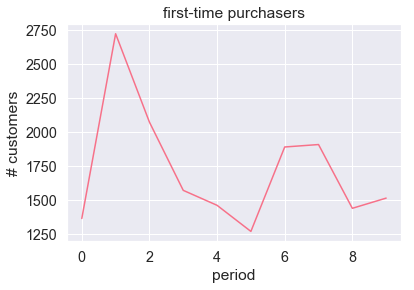

In [78]:
# examine new customers for each year
plt.plot(n_new_purch)
plt.title('first-time purchasers')
plt.xlabel('period')
plt.ylabel('# customers');

There is no obvious trend and sample size is small, so we model the number of new customers each year as a gaussian distribution with mean and standard deviation of the historical data.

In [79]:
# get average number of new customers each year
mu = n_new_purch.mean()
sigma = n_new_purch.std()

def new_customers():
    return sigma * np.random.randn() + mu

print('μ: {}\nσ:  {:.1f}'.format(mu, sigma))

μ: 1719.2
σ:  416.6


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


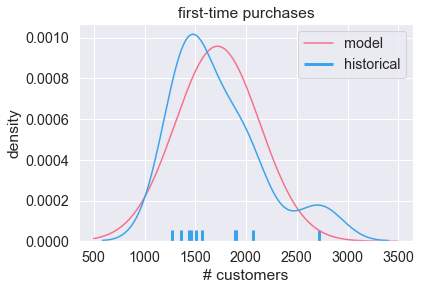

In [82]:
# plot histogram of new customers
X = stats.norm(mu, sigma)
x = np.arange(500, 3500)
y = X.pdf(x)
plt.plot(x, y)
sns.distplot(n_new_purch,
             hist=False,
             rug=True,
             rug_kws=dict(linewidth=3),
             color=blue)
plt.title('first-time purchases')
plt.xlabel('# customers')
plt.ylabel('density')
plt.legend(['model', 'historical']);

In [83]:
# get proportional probabilities for new customers entering the system
new_cust_p = T_prob[0, 1:5]
new_customer_prop = new_cust_p / new_cust_p.sum()
new_customer_prop

array([0.06252908, 0.61255235, 0.00360633, 0.32131224])

In [84]:
## refactor transition matrix and reward vectors to allow new customers to enter the system

T_prob_proj = T_prob.copy()
T_prob_proj[0, 0] = 0
T_prob_proj[0, 1:5] = new_customer_prop

# reward vector, no implementation of policy
r_proj_no_policy = np.zeros(22)
r_proj_no_policy[1:] = r.copy()

# reward vector, with policy implementation
r_proj_policy = np.zeros(22)
r_proj_policy[1:] = r.copy()*policy.copy()

In [85]:
## project 10 years of revenue, 10000 trials

# set periods to project
y = 10
num_trials = 10000
trials_no_policy = np.zeros((num_trials, y))
trials_policy = np.zeros((num_trials, y))

for trial in range(num_trials):
    # initialize customer distribution
    customer_dist = state_counts.copy()[:, -1]
    for year in range(y):
        customer_dist[0] += new_customers()
        customer_dist = np.dot(customer_dist, T_prob_proj)
        # without implementing policy (churn at 6 periods)
        trials_no_policy[trial, year] = np.dot(customer_dist, r_proj_no_policy)*discount**(year+1)
        # with the recommended policy
        trials_policy[trial, year] = np.dot(customer_dist, r_proj_policy)*discount**(year+1)

# get mean and std for all trials
no_pol_mu = trials_no_policy.mean(axis=0)
no_pol_sig = trials_no_policy.std(axis=0)

pol_mu = trials_policy.mean(axis=0)
pol_sig = trials_policy.std(axis=0)

Now that we have net income projections, lets compare the policies.

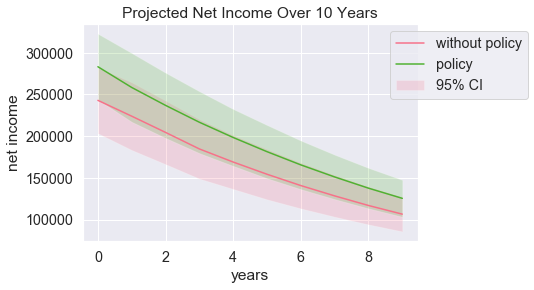

In [87]:
# calculate and plot means and confidence intervals
no_pol_up_ci = no_pol_mu + 1.96*no_pol_sig
no_pol_down_ci = no_pol_mu - 1.96*no_pol_sig
plt.plot(no_pol_mu)
plt.fill_between(np.arange(10),
                     no_pol_up_ci,
                     no_pol_down_ci,
                     alpha=.2)

pol_up_ci = pol_mu + 1.96*pol_sig
pol_down_ci = pol_mu - 1.96*pol_sig
plt.plot(pol_mu)
plt.fill_between(np.arange(10),
                     pol_up_ci,
                     pol_down_ci,
                     alpha=.2,
                     facecolor=green)

plt.xlabel('years')
plt.ylabel('net income')
plt.title('Projected Net Income Over 10 Years')
plt.legend(['without policy', 'policy', '95% CI'], bbox_to_anchor=(1.35, 1));

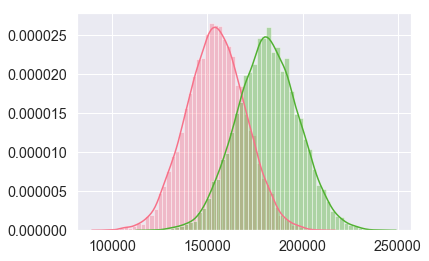

In [88]:
# check output histograms
sns.distplot(trials_no_policy[:, 5], bins=50)
sns.distplot(trials_policy[:, 5], bins=50);

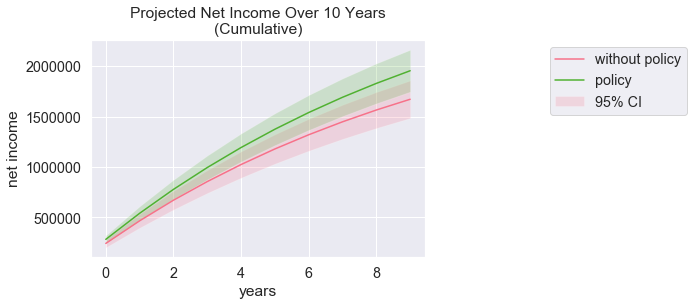

In [90]:
## cumulative revenue over 10 years

# get mean and std
no_pol_cum = trials_no_policy.cumsum(axis=1)
no_pol_cum_mu = no_pol_cum.mean(axis=0)
no_pol_cum_sig = no_pol_cum.std(axis=0)

pol_cum = trials_policy.cumsum(axis=1)
pol_cum_mu = pol_cum.mean(axis=0)
pol_cum_sig = pol_cum.std(axis=0)

# calculate confidence intervals
no_pol_cum_up_ci = no_pol_cum_mu + 1.96*no_pol_cum_sig
no_pol_cum_down_ci = no_pol_cum_mu - 1.96*no_pol_cum_sig
# plot
plt.plot(no_pol_cum_mu)
plt.fill_between(np.arange(10),
                     no_pol_cum_up_ci,
                     no_pol_cum_down_ci,
                     alpha=.2)

# calculate confidence intervals
pol_cum_up_ci = pol_cum_mu + 1.96*pol_cum_sig
pol_cum_down_ci = pol_cum_mu - 1.96*pol_cum_sig
# plot
plt.plot(pol_cum_mu)
plt.fill_between(np.arange(10),
                     pol_cum_up_ci,
                     pol_cum_down_ci,
                     alpha=.2,
                     facecolor=green)

# labels
plt.xlabel('years')
plt.ylabel('net income')
plt.title('Projected Net Income Over 10 Years\n(Cumulative)')
plt.legend(['without policy', 'policy', '95% CI'], bbox_to_anchor=(1.35, 1));

In [91]:
# total revenue over 10 years (no policy)
r_n = no_pol_cum_mu[-1]
r_n_up_ci = no_pol_cum_mu[-1] + 1.96*no_pol_cum_sig[-1]
r_n_down_ci = no_pol_cum_mu[-1] - 1.96*no_pol_cum_sig[-1]

# total revenue over 10 years (with policy)
r_p = pol_cum_mu[-1]
r_p_up_ci = pol_cum_mu[-1] + 1.96*pol_cum_sig[-1]
r_p_down_ci = pol_cum_mu[-1] - 1.96*pol_cum_sig[-1]

print('''With Policy
-------------------------------
projected net income: {:.2f}
95% CI [{:.2f}, {:.2f}]

Without Policy
-------------------------------
projected net income: {:.2f}
95% CI [{:.2f}, {:.2f}]'''.format(r_p, r_p_down_ci, r_p_up_ci,
                                  r_n, r_n_down_ci, r_n_up_ci))

With Policy
-------------------------------
projected net income: 1954754.08
95% CI [1746692.90, 2162815.25]

Without Policy
-------------------------------
projected net income: 1671965.91
95% CI [1485458.90, 1858472.93]


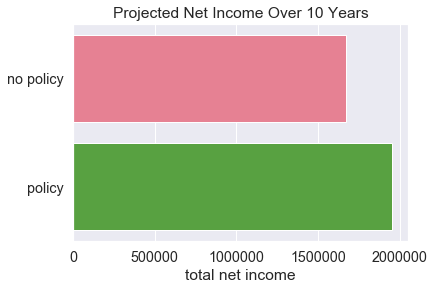

In [94]:
# comparison
plt.xlabel('total net income')
plt.title('Projected Net Income Over 10 Years')
sns.barplot(x=[r_n, r_p], y=['no policy', 'policy'], orient='h');

In [95]:
# policy savings
savings = pol_cum - no_pol_cum
savings_mu = savings.mean(axis=0)[-1]
savings_sig = savings.std(axis=0)[-1]
savings_up_ci = savings_mu + 1.96*savings_sig
savings_down_ci = savings_mu - 1.96*savings_sig

print('''Estimated savings over 10 years: {:.2f}
95% CI: [{:.2f}, {:.2f}]'''.format(savings_mu, savings_down_ci, savings_up_ci))

Estimated savings over 10 years: 282788.16
95% CI: [260684.00, 304892.32]


So the policy saves around \$470k over ten years. Not bad for a day's work! This policy should be implemented immediately.

It should be noted that 10 years is quite a long time to make projections. This model should be updated every period as new data come in.

Another question arises: what would the impact have been if we had implemented this policy over the historical period?

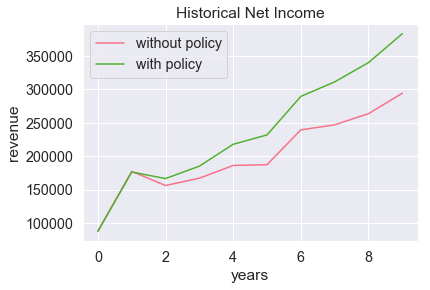

In [96]:
# get count of marketing targets for each historical period
cost_count_no_policy = (S > 0).astype(int).sum(axis=0)
cost_count_with_policy = np.logical_and(S < 11,
                                        np.logical_and(S > 0,
                                                       np.logical_and(S != 7, 
                                                                      S != 8)))
cost_count_with_policy = cost_count_with_policy.astype(int).sum(axis=0)
# get total costs per period
costs_no_policy = cost_count_no_policy*cost
costs_with_policy = cost_count_with_policy*cost

# subtract marketing costs from historical revenue
hist_rev_no_policy  = mon.sum().values - costs_no_policy

# implementing the policy means missing out on purchases by returning churners
# so adjust the historical revenue accordingly
hist_rev_with_policy  = (1 - percent_missed_purchases)*mon.sum().values -\
                        costs_with_policy

plt.plot(hist_rev_no_policy[1:])
plt.plot(hist_rev_with_policy[1:])
plt.xlabel('years')
plt.ylabel('revenue')
plt.title('Historical Net Income')
plt.legend(['without policy', 'with policy'], loc=2);

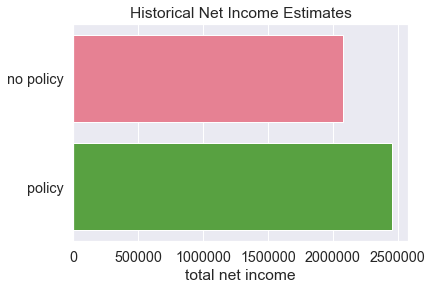

In [98]:
# estimated revenue if the policy had been implemented on
# historical data
rh_n = hist_rev_no_policy.sum()
rh_p = hist_rev_with_policy.sum()

plt.xlabel('total net income')
plt.title('Historical Net Income Estimates')
sns.barplot(x=[rh_n, rh_p], y=['no policy', 'policy'], orient='h');

In [99]:
# estimated savings
print('estimated savings on last 10 years: {:.2f}'.format(rh_p - rh_n))

estimated savings on last 10 years: 381090.57


So our policy would have saved \$380k over the last 10 years.

How good are these models, really? Well, they are generative. Projections are made by feeding new data into the model and simulating customer behavior, ie. turning the crank. By feeding historical data back into the model, we can see how it would do with data that we've already seen.

This model will probably be updated with new data every period or so, so I've only plotted projections over 1-year.

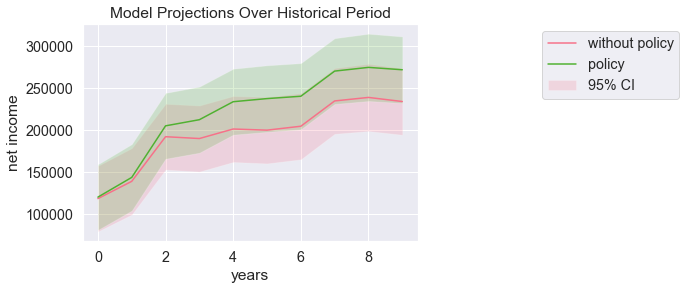

In [100]:
# set periods to project
y = 10
num_trials = 10000
# initialize simulation arrays
sim_no_policy = np.zeros((num_trials, y))
sim_policy = np.zeros((num_trials, y))

for trial in range(num_trials):
    ## simulate each year
    for year in range(y):
        # get current customer distribution
        customer_dist = state_counts.copy()[:, year]
        # add new first time purchasers for next period
        customer_dist[0] = new_customers()
        # get projected distribution for next period
        customer_dist = np.dot(customer_dist, T_prob_proj)

        ## calculate revenue
        # without implementing policy (churn at 6 periods)
        sim_no_policy[trial, year] = np.dot(customer_dist, r_proj_no_policy)*discount
        # with the recommended policy
        sim_policy[trial, year] = np.dot(customer_dist, r_proj_policy)*discount

# get mean and std for all trials
sim_no_pol_mu = sim_no_policy.mean(axis=0)
sim_no_pol_sig = sim_no_policy.std(axis=0)

sim_pol_mu = sim_policy.mean(axis=0)
sim_pol_sig = sim_policy.std(axis=0)        

# calculate and plot means and confidence intervals
sim_no_pol_up_ci = sim_no_pol_mu + 1.96*sim_no_pol_sig
sim_no_pol_down_ci = sim_no_pol_mu - 1.96*sim_no_pol_sig
plt.plot(sim_no_pol_mu)
plt.fill_between(np.arange(10), 
                     sim_no_pol_up_ci, 
                     sim_no_pol_down_ci, 
                     alpha=.2)

sim_pol_up_ci = sim_pol_mu + 1.96*sim_pol_sig
sim_pol_down_ci = sim_pol_mu - 1.96*sim_pol_sig
plt.plot(sim_pol_mu)
plt.fill_between(np.arange(10), 
                     sim_pol_up_ci, 
                     sim_pol_down_ci, 
                     alpha=.2, 
                     facecolor=green)

# labels
plt.xlabel('years')
plt.ylabel('net income')
plt.title('Model Projections Over Historical Period')
plt.legend(['without policy', 'policy', '95% CI'], bbox_to_anchor=(1.35, 1));

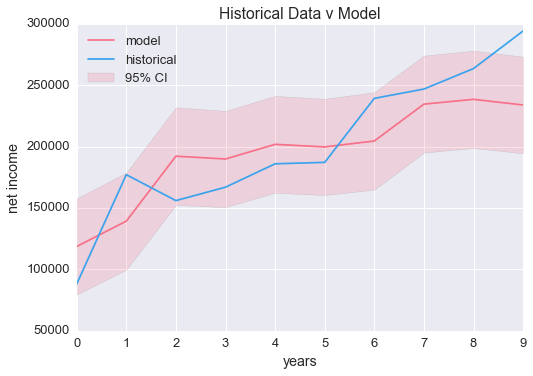

In [54]:
## the first simulation is projected from the first year, so its
## predictions should be compared with historical data from the 
## second year forward

sns.plt.plot(sim_no_pol_mu)
sns.plt.fill_between(np.arange(10),
                     sim_no_pol_up_ci,
                     sim_no_pol_down_ci,
                     alpha=.2)
sns.plt.plot(hist_rev_no_policy[1:], color=blue)
sns.plt.xlabel('years')
sns.plt.ylabel('net income')
sns.plt.title('Historical Data v Model')
sns.plt.legend(['model', 'historical', '95% CI'], loc=2);

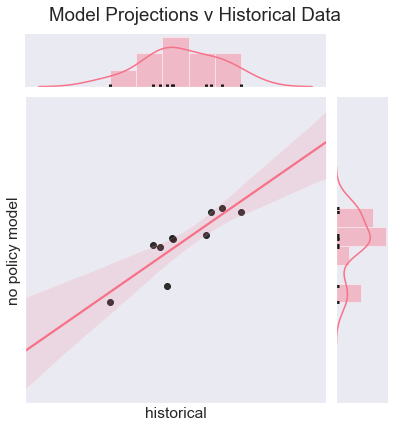

In [101]:
# linear model comparing simulations with historical data
sns.jointplot(hist_rev_no_policy[1:], sim_no_pol_mu, kind='reg', 
              joint_kws=dict(scatter_kws=dict(color='k', alpha=.9)), 
              marginal_kws=dict(bins=5, rug=True, 
                                rug_kws=dict(color = 'k', linewidth=3)))
plt.xticks([])
plt.yticks([])
plt.suptitle('Model Projections v Historical Data', y=1.01)
plt.xlabel('historical')
plt.ylabel('no policy model');